# Assignment 2

In [68]:
# some imports to be used in this assignment(
import sklearn
from sklearn import datasets
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import heapq
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from math import sqrt
from time import time
from sklearn import metrics
from sklearn.utils.extmath import density
import matplotlib.pyplot as plt
import numpy as np


### loads a train and test out of the ohsumed files

In [128]:
data_train = sklearn.datasets.load_files(container_path=".\\ohsumed-first-20000-docs\\training", categories=None,
                                shuffle=True, random_state=42)
data_test = sklearn.datasets.load_files(container_path=".\\ohsumed-first-20000-docs\\test", categories=None,
                                shuffle=True, random_state=42)

## Question 1

### The funtion in this section counts the number of docs from each category. The output of this section is in 'categories count.txt' file

In [129]:
def countCategoriesUsage(categories, documentsCategoriesArray):
    '''
    Gets categories array and an array of indices of those categories in categories array.
    Returns an array of how many docs there are in each category
    '''
    categoriesDict = {}
    for val in documentsCategoriesArray:
        if categories[val] in categoriesDict:
            categoriesDict[categories[val]]=categoriesDict[categories[val]]+1
        else:
            categoriesDict[categories[val]] = 1
    return categoriesDict
    
# prints for each category in the train, the amount of documents under specific category
print(countCategoriesUsage(data_train.target_names, data_train.target))

{'C12 Urologic and Male Genital Diseases': 491, 'C21 Disorders of Environmental Origin': 546, 'C22 Animal Diseases': 92, 'C14 Cardiovascular Diseases': 1249, 'C03 Parasitic Diseases': 65, 'C16 Neonatal Diseases and Abnormalities': 200, 'C17 Skin and Connective Tissue Diseases': 295, 'C15 Hemic and Lymphatic Diseases': 215, 'C13 Female Genital Diseases and Pregnancy Complications': 281, 'C23 Pathological Conditions, Signs and Symptoms': 1799, 'C06 Digestive System Diseases': 588, 'C11 Eye Diseases': 162, 'C08 Respiratory Tract Diseases': 473, 'C18 Nutritional and Metabolic Diseases': 388, 'C19 Endocrine Diseases': 191, 'C20 Immunologic Diseases': 525, 'C01 Bacterial Infections and Mycoses': 423, 'C04 Neoplasms': 1163, 'C05 Musculoskeletal Diseases': 283, 'C07 Stomatognathic Diseases': 100, 'C09 Otorhinolaryngologic Diseases': 125, 'C10 Nervous System Diseases': 621, 'C02 Virus Diseases': 158}


### Cleaning and normalizing the text function

In [7]:
# We've cleaned and normalize our training corpus and above all filtered some used terms for the next reason: 
# We understood that for better results for some vectorizers (e.g. counting vectorizer), it would be best if we clean common 
# used terms in our categories, because they would be less meaningful (tf-idf takes this parameter in account so we believe
# that not only it filtering those words would not deliver any benefit, but even can degrade its produced data).
# Our initial approach was to try and find manually the terms that are in the top ten of many of the categories.
# We were aware of the fact that when words are filtered from the top ten most common terms per categories, new terms
# can be retrieved and are needed to be added to our filtered words list, thus, the idea of working in iterations have been
# created, we filter words in a loop until enough words have been filtered.
# The next terms came from iterations over the code in which we found them to be used in more than 0.25 of 
# the categories. those are the iterations and the terms we found in each of them:
# 1. le group cell treatment patient case study disease p
# 2. treatment result cell infection may effect
# 3. level year one two clinical control syndrome
# 4. human therapy 2 associated normal blood
# 5. rate 1
# 6. antibody
# meaning those are our filtered words: set()#u'patient le p group study case disease treatment result cell infection may effect level year one two clinical control syndrome human therapy 2 associated normal blood rate 1 antibody'.split()

# After finding all those words to filter, we've decided we can do better by letting our code do those iterations for us.
# We've encapsulated all beneath functions in a single function so we can run them again and again until 
# all top words are filtered (meaning fix-point was reached). We've also printed the words we've filtered in each iteration.

def clean():
    '''
    Returns cleaned and normalized documents as shown in class.
    '''
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    cleaned_train_with_category = []
    for doc, target in zip(data_train.data, data_train.target):
        stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
        punc_free = ''.join(ch if ch not in exclude else ' ' for ch in stop_free)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        cleaned_train_with_category.append((normalized.split(),data_train.target_names[target]))
    return cleaned_train_with_category

### For every category, counts for each term how many times it has been used. using heap data structure, gets the top ten most common terms in each category.
#### Note: be aware that even though some of the terms looks meaningless, we've decided to not filter them out because we believe it contributes to better classifying the document by its document structure (e.g. HTML) even though those terms looks meaningful to us.

In [8]:
def count_terms_in_categories(cleaned_train_with_category):
    '''
    for every category, counts the number of times each term has been used,
    uses a dictionary of category-dictionaries
    '''
    # an array with the size of the number of dictionaries, 
    # each dictionary holds a dictionary that maps every term to the number of times it is used
    categories_dictionaries = {}
    # initialize all categories
    for category in data_train.target_names:
        categories_dictionaries[category] = {}
    for (terms, category) in cleaned_train_with_category:
        for term in terms:
            if term in categories_dictionaries[category]:
                categories_dictionaries[category][term] = categories_dictionaries[category][term] + 1
            else:
                categories_dictionaries[category][term] = 1
    return categories_dictionaries

def filter_words(categories_dictionaries, filtered_words):
    '''
    Removes terms from the categories_dictionaries we wish to filter
    '''
    for category in categories_dictionaries.keys():
        for filtered_word in filtered_words:
            categories_dictionaries[category].pop(filtered_word, None)
            
def get_top_ten_of_categories(categories_dictionaries):
    '''
    Using heaps, stores for each category its 10 most used terms
    '''
    top_10_terms = {}
    for category, terms in categories_dictionaries.iteritems():
        heap = [(-value, key) for key,value in terms.items()]
        largest = heapq.nsmallest(10, heap)
        largest = [key for value, key in largest] #[(key, -value) for value, key in largest]
        top_10_terms[category] = largest
    return top_10_terms

### The next functions are responsible for finding the words we want to filter

In [ ]:
def count_terms_usage_in_top_ten(top_10_terms):
    '''
    counts the number of times each word has been seen in the given heaps.
    '''
    terms_counter = {}
    for category, terms in top_10_terms.iteritems():
        for term in terms:
            if term in terms_counter:
                terms_counter[term] = terms_counter[term] + 1
            else:
                terms_counter[term] = 1
    return terms_counter
                
def get_words_needed_to_be_filtered(terms_counter, min_percent_of_categories):
    '''
    Returns all terms that are needed to be filtered, 
    a term is needed to be filtered amount of times iff 
    (number of times it is in the top ten > min_percent_of_categories * number of categories)
    '''
    to_filter = set()
    for term, counter in terms_counter.iteritems():
        if(counter > min_percent_of_categories * len(data_train.target_names)):
            to_filter.add(term)
    return to_filter

### The next section is responsible for running all the above as explained in fixed-point fasioned way, and displays a table of the top ten words used for each category after filtering all unwanted words (as described above). The ouput of this section is in 'filtered and top ten.png' file

#### Note: we filtered all words that are shown in more than 10% of the categories top words, in our case it means that if a word is in 3 categories or more, it should be filtered.
#### Another note: we took note that not too many words are filtered, around 95 terms are filtered out of more than 20,000 

In [9]:
# the words we wouldbe filtering will be gathered in this variable
total_filtered_words = set()
def display_top_ten_terms_after_filter(min_percent_of_categories):
    '''
    Returns a top ten table after filtering all unwanted words.
    '''
    global total_filtered_words
    filtered_words = set("just for loop enter")
    top_10_terms = {}
    total_filtered_words = set()
    cleaned_train_with_category = clean()
    categories_dictionaries = count_terms_in_categories(cleaned_train_with_category)
    while len(filtered_words) != 0:
        top_10_terms = get_top_ten_of_categories(categories_dictionaries)
        terms_counter = count_terms_usage_in_top_ten(top_10_terms)
        filtered_words = get_words_needed_to_be_filtered(terms_counter, min_percent_of_categories)
        total_filtered_words = total_filtered_words.union(filtered_words)
        if len(filtered_words) != 0:
            print("the words to filter in the next iteration: " + repr(filtered_words))
        filter_words(categories_dictionaries, filtered_words)
    return top_10_terms
   
top_10_terms = display_top_ten_terms_after_filter(0.1)
display(pd.DataFrame.from_dict(data=top_10_terms))

the words to filter in the next iteration: set([u'case', u'cell', u'le', u'group', u'p', u'study', u'disease', u'infection', u'1', u'0', u'2', u'treatment', u'human', u'year', u'patient', u'tumor'])
the words to filter in the next iteration: set([u'control', u'associated', u'syndrome', u'cancer', u'level', u'may', u'normal', u'two', u'one', u'3', u'clinical', u'5', u'result', u'serum', u'effect', u'antibody', u'day', u'4'])
the words to filter in the next iteration: set([u'virus', u'lesion', u'risk', u'child', u's', u'increased', u'three', u'rate', u'tissue', u'therapy', u'blood', u'6', u'artery', u'carcinoma', u'subject'])
the words to filter in the next iteration: set([u'10', u'diagnosis', u'hiv', u'age', u'month', u'7', u'factor', u'8', u'surgery', u'stage', u'treated', u'response', u'mean'])
the words to filter in the next iteration: set([u'acute', u'woman', u'significantly', u'chronic', u'antigen', u'ventricular', u'pressure', u'compared', u'infected', u'significant', u'found', u'

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23
0,b,immunodeficiency,parasite,breast,knee,gastric,periodontal,respiratory,ear,cerebral,eye,renal,pregnancy,left,anemia,infant,skin,insulin,glucose,aid,injury,model,12
1,culture,aid,falciparum,primary,hip,liver,gland,pneumonia,nasal,brain,retinal,bladder,fetal,myocardial,hemoglobin,defect,arthritis,glucose,insulin,immunodeficiency,alcohol,animal,used
2,bacterial,htlv,malaria,malignant,joint,ulcer,primary,nasal,hearing,muscle,visual,prostate,pregnant,hypertension,platelet,right,rheumatoid,diabetic,thyroid,asthma,fracture,mouse,four
3,antibiotic,i,cerebral,node,arthritis,bowel,oral,increase,loss,stroke,ocular,urinary,maternal,aortic,sickle,congenital,psoriasis,diabetes,diabetic,lymphoma,trauma,induced,graft
4,h,measles,drug,dna,fracture,bile,dental,infant,laryngeal,nerve,intraocular,dialysis,delivery,flow,transfusion,abnormality,ra,cholesterol,diabetes,test,use,kg,20
5,pylorus,ii,rosetting,metastasis,muscle,biliary,parotid,airway,histamine,showed,macular,function,outcome,ischemia,iron,flow,cutaneous,concentration,hormone,il,ethanol,venous,9
6,sepsis,among,peptide,analysis,showed,esophageal,salivary,small,allergic,stimulation,technique,kidney,among,infarction,marrow,left,contact,dependent,parathyroid,b,used,concentration,death
7,cause,lymphocyte,c,receptor,disc,hepatic,lip,12,rhinitis,seizure,posterior,creatinine,test,death,l,anomaly,inflammatory,niddm,l,beta,burn,dog,postoperative
8,use,related,leishmaniasis,resection,total,duct,cleft,chest,middle,spinal,detachment,ml,activity,arterial,count,surgical,drug,acid,hypothyroidism,skin,related,observed,surgical
9,c,seropositive,onchocerciasis,four,activity,stone,report,oxygen,report,finding,glaucoma,prostatic,ectopic,right,increase,cystic,induced,mellitus,hyperparathyroidism,lymphocyte,care,experimental,per


## Question 2.

In [10]:
# We believed we could be using the filtered words for acheiving better results when we were using CountVectorizer, and so
# we've followed through with the idea we had in mind that we should try this question for both, the original corpus and
# a one we've been cleaning and normalizing from question 1.

def clean_with_filtered():
    '''
    get the train_data after fully filtering applied.
    '''
    global total_filtered_words
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    cleaned_train_with_category = []
    for doc, target in zip(data_train.data, data_train.target):
        stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
        punc_free = ''.join(ch if ch not in exclude else ' ' for ch in doc.lower())
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        filtered = " ".join([i for i in normalized.split() if i not in total_filtered_words])
        cleaned_train_with_category.append(filtered)
    return cleaned_train_with_category

cleaned_train_with_category = clean_with_filtered()

### We chose to try CountVectorizer and TfidfVectorizer for feature extraction, and Naive Bayes (MultinomialNB), k-nearest neighbors (KNeighborsClassifier) and Neural network (MLPClassifier) for machine learning models. So we've used pipeline for the six pairs:<br>(CountVectorizer, MultinomialNB)<br> (TfidfVectorizer, MultinomialNB)<br>(CountVectorizer, KNeighborsClassifier)<br>(TfidfVectorizer, KNeighborsClassifier)<br>(CountVectorizer, MLPClassifier)<br>(TfidfVectorizer, MLPClassifier)<br>The output to this sections can be found in the attached files by the pair's name, i.e. for the first section: '1 - countVectorizer + naiveBayes.png'
#### We were not asked in the assignment document to unify the feature extractors so we've decided it would benefit us most to not use feature union method and not merge the two feature extraction to one, because we truly want to get our hands on those 6 possibilities and make a massive comparison between those 6 (and not just 3).
#### We used the next 6 code segments to find out the best parameters for each object in each pair. Initialy, we did all 6 for both, our filtered corpus and the original corpus. Sadly, we found that for some unknown reason, the score of using the original corpus is better than using the filtered corpus. After many tests for this parameteres we've decided to stop to check for both of them because it consumes too much time and so the final output of this sections sometimes not covering the filtered corpus.
#### Important note: We wanted  to use k-fold validation to achieve greater results, but you've pointed us that the pipeline already does that for us (truely does - as mentioned in best score description) - which is awesome :).

In [98]:
#1 - using CountVectorizer and MultinomialNB
nb_clf = Pipeline([('vect', CountVectorizer(stop_words = stopwords.words('english'), ngram_range= (1, 1))),
                   ('clf', MultinomialNB())])

parameters = {'clf__alpha' : (0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0),
                'vect__min_df':(0.0,0.1,0.2,0.3),
                'vect__max_df':(0.7,0.8,0.9,1.0)}

gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=4)
gs_clf = gs_clf.fit(data_train.data,data_train.target)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)

('Best score: ', 0.31352439375059904)
('Best params: ', {'vect__max_df': 0.7, 'vect__min_df': 0.0, 'clf__alpha': 0.8})


In [99]:
#2 - using TfidfVectorizer and MultinomialNB
nb_clf = Pipeline([('vect', TfidfVectorizer(stop_words = stopwords.words('english'), ngram_range= (1, 1))),
                   ('clf', MultinomialNB())])

parameters = {'clf__alpha' : (0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0),
                'vect__min_df':(0.0,0.1,0.2,0.3),
                'vect__max_df':(0.7,0.8,0.9,1.0)}

gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=4)
gs_clf = gs_clf.fit(data_train.data,data_train.target)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)
print
gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=4)
gs_clf = gs_clf.fit(cleaned_train_with_category,data_train.target)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)

('Best score: ', 0.26876258027413014)
('Best params: ', {'vect__max_df': 0.7, 'vect__min_df': 0.0, 'clf__alpha': 0.1})

('Best score: ', 0.2649285919677945)
('Best params: ', {'vect__max_df': 0.7, 'vect__min_df': 0.0, 'clf__alpha': 0.1})


In [100]:
#3 - using CountVectorizer and KNeighborsClassifier
nb_clf = Pipeline([('vect', CountVectorizer(stop_words = stopwords.words('english'), ngram_range= (1, 1))),
                   ('clf', KNeighborsClassifier())])

parameters =  {'clf__n_neighbors':(30,40,50),
                'clf__weights':('uniform','distance'), 
                'clf__algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'),
                'vect__min_df':(0.0,0.1,0.2,0.3),
                'vect__max_df':(0.7,0.8,0.9,1.0)}

gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=4)
gs_clf = gs_clf.fit(data_train.data,data_train.target)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)
print
gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=4)
gs_clf = gs_clf.fit(cleaned_train_with_category,data_train.target)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)

('Best score: ', 0.22026262819898398)
('Best params: ', {'clf__weights': 'uniform', 'vect__max_df': 0.7, 'clf__algorithm': 'auto', 'vect__min_df': 0.0, 'clf__n_neighbors': 30})

('Best score: ', 0.19045336911722419)
('Best params: ', {'clf__weights': 'uniform', 'vect__max_df': 0.7, 'clf__algorithm': 'auto', 'vect__min_df': 0.0, 'clf__n_neighbors': 30})


In [102]:
#4 - using TfidfVectorizer and KNeighborsClassifier
nb_clf = Pipeline([('vect', TfidfVectorizer(stop_words = stopwords.words('english'), ngram_range= (1, 1))),
                   ('clf', KNeighborsClassifier())])

parameters =  {'clf__n_neighbors':(30,40,50),
                'clf__weights':('uniform','distance'), 
                'clf__algorithm':('auto', 'ball_tree', 'kd_tree', 'brute'),
                'vect__min_df':(0.0,0.1,0.2,0.3),
                'vect__max_df':(0.7,0.8,0.9,1.0)}

gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=4)
gs_clf = gs_clf.fit(data_train.data,data_train.target)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)
print
gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=4)
gs_clf = gs_clf.fit(cleaned_train_with_category,data_train.target)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)

('Best score: ', 0.39739288795169175)
('Best params: ', {'clf__weights': 'uniform', 'vect__max_df': 0.7, 'clf__algorithm': 'auto', 'vect__min_df': 0.0, 'clf__n_neighbors': 40})

('Best score: ', 0.39183360490750502)
('Best params: ', {'clf__weights': 'uniform', 'vect__max_df': 0.7, 'clf__algorithm': 'auto', 'vect__min_df': 0.0, 'clf__n_neighbors': 40})


In [113]:
#5 - using CountVectorizer and MLPClassifier
nb_clf = Pipeline([('vect', CountVectorizer(stop_words = stopwords.words('english'), ngram_range= (1, 1), max_df=1.0)),
                   ('clf', MLPClassifier())])

parameters =  {'vect__min_df':(0.0,0.3),
               'clf__hidden_layer_sizes': ((100,),((int(sqrt(len(data_train.data))),)))}

gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=4)
gs_clf = gs_clf.fit(data_train.data,data_train.target)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)

('Best score: ', 0.24125371417617175)
('Best params: ', {'clf__hidden_layer_sizes': (102,), 'vect__min_df': 0.0})


In [114]:
#6 - using TfidfVectorizer and MLPClassifier
nb_clf = Pipeline([('vect', TfidfVectorizer(stop_words = stopwords.words('english'), ngram_range= (1, 1), max_df=1.0)),
                   ('clf', MLPClassifier())])

parameters =  {'vect__min_df':(0.0,0.3),
               'clf__hidden_layer_sizes': ((100,),((int(sqrt(len(data_train.data))),)))}

gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=4)
gs_clf = gs_clf.fit(data_train.data,data_train.target)
print('Best score: ',gs_clf.best_score_)
print('Best params: ',gs_clf.best_params_)

102
('Best score: ', 0.24920923991181826)
('Best params: ', {'clf__hidden_layer_sizes': (100,), 'vect__min_df': 0.0})


### In this section we are evaluating each and every vectorizer and model with the best parameters we could've found in the 6 sections above and compare them to each other. You can find the output text in 'final scores.txt' file and the graphs which compare them in 'final scores.png' file.

Vectorizer: Count vectorizer
Model: Naive Bayes
________________________________________________________________________________
Training: 
CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.7, max_features=None, min_df=0.0,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'w...n', u'ma', u'mightn', u'mustn', u'needn', u'shan', u'shouldn', u'wasn', u'weren', u'won', u'wouldn'],
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
MultinomialNB(alpha=0.8, class_prior=None, fit_prior=True)
train time: 5.724s
test 

train time: 8.083s
test time:  43.163s
accuracy:   0.254
classification report:
             precision    recall  f1-score   support

        C01       0.23      0.05      0.08       506
        C02       0.21      0.01      0.02       233
        C03       0.00      0.00      0.00        70
        C04       0.22      0.76      0.35      1467
        C05       0.33      0.05      0.09       429
        C06       0.48      0.11      0.18       632
        C07       0.00      0.00      0.00       146
        C08       0.26      0.13      0.17       600
        C09       0.50      0.04      0.07       129
        C10       0.22      0.04      0.07       941
        C11       0.42      0.05      0.09       202
        C12       0.35      0.19      0.24       548
        C13       0.35      0.18      0.24       386
        C14       0.51      0.35      0.41      1301
        C15       0.21      0.02      0.04       320
        C16       0.00      0.00      0.00       228
        C17       

train time: 775.545s
test time:  7.153s
accuracy:   0.425
classification report:
             precision    recall  f1-score   support

        C01       0.39      0.34      0.36       506
        C02       0.44      0.13      0.20       233
        C03       0.63      0.27      0.38        70
        C04       0.49      0.68      0.57      1467
        C05       0.51      0.28      0.36       429
        C06       0.48      0.44      0.46       632
        C07       0.60      0.06      0.11       146
        C08       0.40      0.31      0.35       600
        C09       0.52      0.20      0.29       129
        C10       0.47      0.36      0.41       941
        C11       0.48      0.36      0.41       202
        C12       0.52      0.34      0.41       548
        C13       0.41      0.41      0.41       386
        C14       0.55      0.63      0.59      1301
        C15       0.44      0.21      0.28       320
        C16       0.43      0.11      0.18       228
        C17      

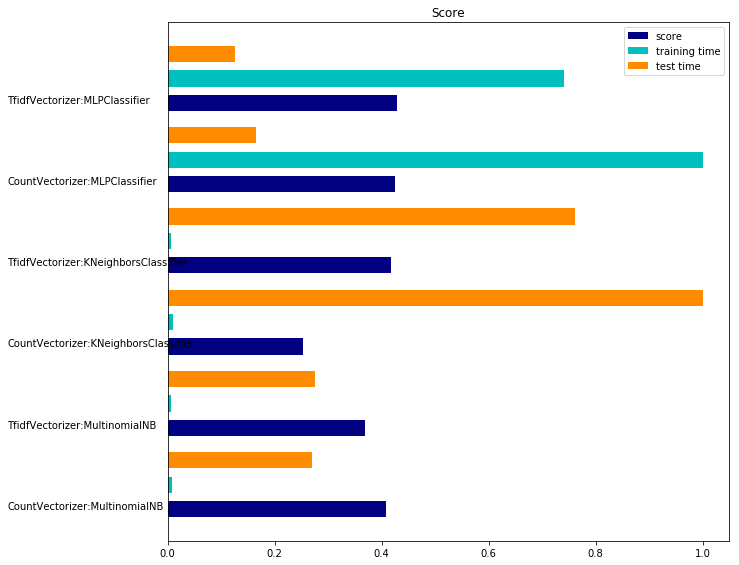

In [126]:
def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

# #############################################################################
# Benchmark classifiers
def benchmark(vectorizer, clf):
    print('_' * 80)
    print("Training: ")
    print(vectorizer)
    print(clf)
    t0 = time()
    X_train = vectorizer.fit_transform(data_train.data)
    clf.fit(X_train, data_train.target)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(vectorizer.transform(data_test.data))
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(data_test.target, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    print("classification report:")
    print(metrics.classification_report(data_test.target, pred,
                                        target_names=data_train.target_names))
    print("confusion matrix:")
    print(metrics.confusion_matrix(data_test.target, pred))

    print()
    descr = str(vectorizer).split('(')[0] + ":" + str(clf).split('(')[0]
    return descr, score, train_time, test_time


results = []
for vect, vectName, clf, clfName in (
        (CountVectorizer(stop_words = stopwords.words('english'), ngram_range= (1, 1),min_df=0.0,max_df=0.7),
         "Count vectorizer",
         MultinomialNB(alpha=0.8),
         "Naive Bayes"),
        (TfidfVectorizer(stop_words = stopwords.words('english'), ngram_range= (1, 1),min_df=0.0,max_df=0.1),
         "Tfidf vectorizer",
         MultinomialNB(alpha=0.1),
         "Naive Bayes"),
        (CountVectorizer(stop_words = stopwords.words('english'), ngram_range= (1, 1),min_df=0.0,max_df=0.7),
         "Count vectorizer",
         KNeighborsClassifier(weights='uniform', algorithm='auto',n_neighbors=30),
         "k-nearest neighbors"),
        (TfidfVectorizer(stop_words = stopwords.words('english'), ngram_range= (1, 1),min_df=0.0,max_df=0.7),
         "Count vectorizer",
         KNeighborsClassifier(weights='uniform', algorithm='auto',n_neighbors=40),
         "k-nearest neighbors"),
        (CountVectorizer(stop_words = stopwords.words('english'), ngram_range= (1, 1),min_df=0.0,max_df=1.0),
         "Count vectorizer",
         MLPClassifier(hidden_layer_sizes=(int(sqrt(len(data_train.data))),)),
         "Neural network"),
         (TfidfVectorizer(stop_words = stopwords.words('english'), ngram_range= (1, 1),min_df=0.0,max_df=1.0),
         "Tfidf vectorizer",
         MLPClassifier(hidden_layer_sizes=(100,)),
         "Neural network"),
        ):
    print('=' * 80)
    print("Vectorizer: " + vectName)
    print("Model: " + clfName)
    results.append(benchmark(vect, clf))
    

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

### To sum up, as we can see the accuracy of each pair as follows (decending order):<br>Vectorizer: Tfidf vectorizer, Model: Neural network, accuracy:   0.429<br>Vectorizer: Count vectorizer, Model: Neural network, accuracy:   0.425<br>Vectorizer: Count vectorizer, Model: k-nearest neighbors, accuracy:   0.417<br>Vectorizer: Count vectorizer, Model: Naive Bayes, accuracy:   0.409<br>Vectorizer: Tfidf vectorizer, Model: Naive Bayes, accuracy:   0.368<br>Vectorizer: Count vectorizer, Model: k-nearest neighbors, accuracy:   0.254<br>Meaning the best combination was tfidf vectorizer with neural network.
### We've got to say that we found it somewhat strange that the accuracy of this test are not correleted with the best score (cross validated) of the pipeline above, and much more than that we find all of the scores we've achieved to be dissatisfying because they are pretty low :(.